# <div align="center"><b> ETIQUETADO - PROYECTO FINAL </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/ruta/de/archivo.ipynb">Ruta archivo</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [2]:
from pathlib import Path
import os, sys, logging, datetime, re

sys.path.append(os.path.abspath("../"))  # Agregar el directorio padre al path

from dotenv import load_dotenv
load_dotenv("../.env.dev")

OPENCV_IO_MAX_IMAGE_PIXELS = 50000 * 50000  # Para imágenes grandes, ej: barrio3Ombues_20180801_dji_pc_3cm.jpg
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(OPENCV_IO_MAX_IMAGE_PIXELS)

import cv2 as cv
from apps_utils.logging import Logging
from apps_config.settings import Config

import apps_etiquetado.procesador_anotaciones_cvat as ProcesadorCVAT
import apps_etiquetado.procesador_anotaciones_mongodb as ProcesadorMongoDB
import apps_etiquetado.procesador_anotaciones_coco_dataset as ProcesadorCOCODataset
import apps_etiquetado.visualizador_coco_dataset as VisualizadorCOCO
from apps_com_s3.procesador_s3 import ProcesadorS3
from pprint import pprint

from apps_utils.types import Metadata

CONFIG = Config().config_data
procesadorS3 = ProcesadorS3()

download_folder = Path(CONFIG["folders"]["download_folder"])
DOWNLOAD_COCO_ANNOTATIONS_FOLDER = download_folder / "coco_annotations"
DOWNLOAD_IMAGES_FOLDER = download_folder / "images"

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [3]:
LOGGER = Logging().logger

LOGGER.info("Configuración cargada correctamente.")

2025-05-25 13:24:41,445 - root - INFO - <module> - Configuración cargada correctamente.


In [ ]:
patch_name1 = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0"
coco_annotations1_path = ProcesadorMongoDB.download_annotations_as_coco_from_mongodb(
    field_name="cvat",
    patches_names=[patch_name1],
    output_filename=DOWNLOAD_COCO_ANNOTATIONS_FOLDER
    / f"{patch_name1}.json",
)
patch_name2 = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_2"
coco_annotations2_path = ProcesadorMongoDB.download_annotations_as_coco_from_mongodb(
    field_name="cvat",
    patches_names=[patch_name2],
    output_filename=DOWNLOAD_COCO_ANNOTATIONS_FOLDER
    / f"{patch_name2}.json",
)
coco_annotations1 = ProcesadorCOCODataset.load_annotations_from_file(coco_annotations1_path)
coco_annotations2 = ProcesadorCOCODataset.load_annotations_from_file(coco_annotations2_path)
patch_metadata1 = ProcesadorMongoDB.get_patch_metadata_from_mongodb(patch_name1)
patch_metadata2 = ProcesadorMongoDB.get_patch_metadata_from_mongodb(patch_name2)
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm"
image_shape = (5426, 4356)  # Altura, Ancho
metadata: Metadata = {
    "pic_name": image_name,
    "image_shape": image_shape,
    "patches": [patch_metadata1, patch_metadata2],
}
merged_annotations = ProcesadorCOCODataset.merge_coco_annotations(metadata, [coco_annotations1, coco_annotations2])
print("Merged Annotations:")
pprint(merged_annotations)

Merged Annotations:
{'annotations': [{'area': 9063.008499999985,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [2916.48, 1630.49, 100.31, 90.35],
                  'category_id': 0,
                  'id': 1,
                  'image_id': 1,
                  'iscrowd': 0,
                  'segmentation': []},
                 {'area': 9813.701999999988,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [3014.3, 1745.71, 99.48, 98.65],
                  'category_id': 0,
                  'id': 2,
                  'image_id': 1,
                  'iscrowd': 0,
                  'segmentation': []},
                 {'area': 5015.564400000015,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [2903.22, 1796.28, 73.78, 67.98],
                  'category_id': 0,
                  'id': 3,
                  'image_id': 1,
                  'iscrow

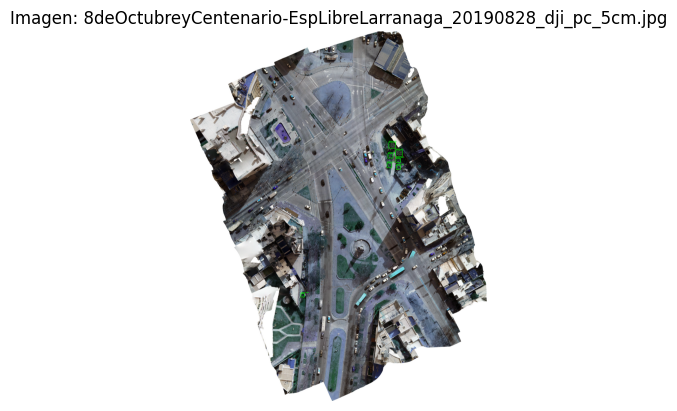

In [7]:
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm"
image_path = procesadorS3.download_image_from_minio(image_name)

VisualizadorCOCO.show_anotated_image(image_path=image_path, coco_annotations=merged_annotations)